In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.shape

(42000, 785)

In [5]:
X = df_train.drop(['label'], axis = 1)
y = df_train['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

test_valid_size = 0.33

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=test_valid_size, random_state=42)

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_valid = X_valid.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
X_final_test = df_test.values.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

X_train.shape

(29400, 28, 28, 1)

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,      # range of rotation angles in degrees
    width_shift_range=0.1,  # range of horizontal shift
    height_shift_range=0.1, # range of vertical shift
    shear_range=0.1,        # range of shear intensity
    zoom_range=0.1,         # range of zoom
    horizontal_flip=True,   # horizontal flipping
    vertical_flip=False,    # vertical flipping
    fill_mode='nearest'     # filling mode for pixels after shift/zoom
)

datagen.fit(X_train, augment = True)

num_augmented_images = 10

X_train_augmented = []
y_train_augmented = []

for x, y in zip(X_train, y_train):
    X_train_augmented.append(x)
    y_train_augmented.append(y)
    for _ in range(num_augmented_images):
        augmented_image = datagen.random_transform(x)  # apply random transformation
        X_train_augmented.append(augmented_image)
        y_train_augmented.append(y)


X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

print(X_train.shape)
print(X_train_augmented.shape)

(29400, 28, 28, 1)
(323400, 28, 28, 1)



Epoch 1/50


 296/2527 [==>...........................] - ETA: 12:09 - loss: 0.8262 - accuracy: 0.7410

KeyboardInterrupt: 

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation = 'softmax'))
model.compile(loss ='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


model_history = model.fit(X_train_augmented, y_train_augmented, batch_size=128, epochs=50, validation_data=(X_valid, y_valid), callbacks = [early_stopping])


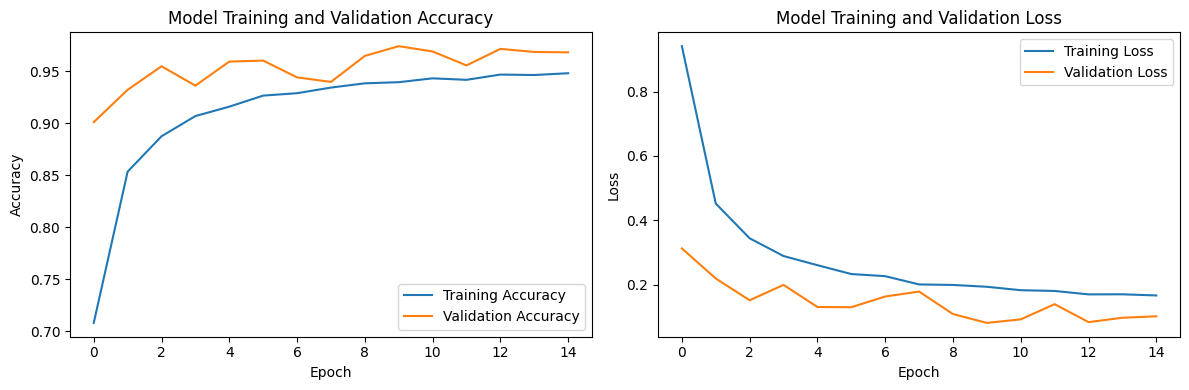

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
accuracy

130/130 [==============================] - 3s 21ms/step


0.9752284752284752

In [ ]:
y_pred_final = model.predict(X_final_test)
y_pred_final = np.argmax(y_pred_final, axis = 1)

submission = pd.DataFrame()
submission['ImageId'] = range(1, len(X_final_test) + 1)
submission['label'] = y_pred_final
submission['label'] = submission['label'].astype(int)
submission.to_csv('submission.csv', index = False)


875/875 [==============================] - 18s 20ms/step
